### Práctica 2 TEE

#### *Alumno: Luis Edward Velo Poma*

#### CASO DE ESTUDIO 2:

El CEO de Dificult Pay ha contratado a UdeP Analytics para que lo asistan en afinar el modelo de negocio de la empresa. Su equipo de analytics interno ha llegado hasta crear las distintas variables de interaccion de los scores de riesgo, pero les falta más experiencia con machine learning para extraer conclusiones accionables para el negocio. 

Difficult Pay recibe 5% del valor de la transacción como comisión, por cada transacción exitosa (verdaderos negativos 0,0), pero pierde el 100% de las transacciones fraudulentas (verdaderos positivos 1,1). Sin embargo, su sistema de riesgo actual es adhoc. El departamento de analistas de Difficult Pay realiza algunos chequeos aleatorios con los bancos para aprobar las transacciones (pero no necesariamente esta decisión está basada en alguno de los scores crediticios con los que cuentan). Además, no siempre registran la data de manera uniforme (por ejemplo, el criterio por el cual se negó la transacción). Esta metodología no permite tener una claridad sobre las cuatro clasificaciones de la matriz de confusión, a priori. Lo que sí sabemos a ciencia cierta es que han habido 153 malas transacciones dentro del dataset de 824 transacciones, las cuales no fueron detectadas por su proceso actual. Como hemos visto en clase, mediante machine learning es posible tener una predicción sobre estos números y completar la matriz de confusión. 

Difficult Pay ha comprado nuestra idea de instalar un modelo crediticio basado en machine learning. Nos ha pedido plantear el mejor modelo utilizando lo aprendido hasta ahora (logit, knn, svm y árboles de decisión) para maximizar el ingreso (o minimizar la pérdida) del negocio. Con el dataset data_cal2024.csv, responder las siguientes preguntas. 

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, TargetEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, average_precision_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import os
import sys
from sklearn.feature_selection import RFECV


In [2]:
# Cargar data
with open('data\data_cal2024.csv') as f:
    df = pd.read_csv(f, header=0, sep=';')

In [3]:
df

,score_1,score_2,riesgo_score1,riesgo_score2,interaccion_1,interaccion_2,monto,mala_transaccion,puntaje_1,puntaje_2,interaccion_suma,estado,cod_postal,ingreso_promedio_estado
0,nd,nd,1,0,0,1,50,0,5,5,10,NC,28525,53687
1,nd,malo,1,1,1,1,59,1,5,4,9,IL,60473,61456
2,nd,malo,1,1,1,1,75,0,5,4,9,SC,29642,52348
3,nd,malo,1,1,1,1,75,0,5,4,9,CA,90220,65895
4,nd,malo,1,1,1,1,75,1,5,4,9,NC,28052,53687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,excelente,excelente,0,0,0,0,100,0,1,1,2,NV,89431,56949
820,excelente,excelente,0,0,0,0,100,0,1,1,2,AZ,85711,58462
821,excelente,excelente,0,0,0,0,100,0,1,1,2,MN,55421,65514
822,excelente,excelente,0,0,0,0,100,0,1,1,2,VA,23518,67918


### Introducción

### **1. Sin utilizar modelo de machine learning aún, cuánto dinero ha ganado o perdido Difficult Pay en estas 824 transacciones. (2 puntos)**


In [4]:
# Definir la comisión y el porcentaje de pérdida
comision = 0.05  # 5% de comisión para transacciones exitosas
perdida = 1.00   # 100% de pérdida para transacciones fraudulentas no detectadas

# Filtrar transacciones exitosas y fraudulentas
transacciones_exitosas = df[df['mala_transaccion'] == 0]
transacciones_fraudulentas = df[df['mala_transaccion'] == 1]

# Calcular las ganancias por transacciones exitosas (5% de cada monto)
ganancias_exitosas = transacciones_exitosas['monto'].sum() * comision

# Calcular las pérdidas por transacciones fraudulentas no detectadas (100% de cada monto)
perdidas_fraudulentas = transacciones_fraudulentas['monto'].sum() * perdida

# Calcular el ingreso neto
ingreso_neto = ganancias_exitosas - perdidas_fraudulentas

print(f"Ganancias por transacciones exitosas: ${ganancias_exitosas:.2f}")
print(f"Pérdidas por transacciones fraudulentas: -${perdidas_fraudulentas:.2f}")
print(f"Ingreso neto de Difficult Pay: ${ingreso_neto:.2f}")

Ganancias por transacciones exitosas: $2490.50
Pérdidas por transacciones fraudulentas: -$11892.00
Ingreso neto de Difficult Pay: $-9401.50


### Resumen de Ganancias y Pérdidas de Difficult Pay

- **Ganancias por transacciones exitosas**: $2,490.50
- **Pérdidas por transacciones fraudulentas**: -$11,892.00
- **Ingreso neto de Difficult Pay**: $-9,401.50

### Conclusión
Difficult Pay ha tenido una **pérdida neta de $9,401.50** en estas 824 transacciones. A pesar de generar ganancias de $2,490.50 en transacciones exitosas, las pérdidas debido a transacciones fraudulentas no detectadas superaron con creces las ganancias. Por lo tanto, el modelo actual no es rentable.

### **2. ¿A cuánto tendría que subir Difficult Pay la comisión por transacción para que el negocio llegase al punto de equilibrio de ingresos (1 punto)?**

In [5]:
# Filtrar transacciones exitosas y fraudulentas
transacciones_exitosas = df[df['mala_transaccion'] == 0]
suma_montos_exitosos = transacciones_exitosas['monto'].sum()

# Pérdidas actuales por transacciones fraudulentas
perdidas_fraudulentas = transacciones_fraudulentas['monto'].sum() * perdida

# Calcular la comisión necesaria para alcanzar el punto de equilibrio
comision_necesaria = perdidas_fraudulentas / suma_montos_exitosos

print(f"Para alcanzar el punto de equilibrio, la comisión debería ser del {comision_necesaria * 100:.2f}% por transacción exitosa.")

Para alcanzar el punto de equilibrio, la comisión debería ser del 23.87% por transacción exitosa.


### **3. Alternativamente, a la tarifa del 5%, cuántas transacciones malas podría haber aceptado Difficult Pay para llegar a al punto de equilibrio. Usar el valor promedio por transaccion para aproximarla. (1 punto)**

In [6]:
# Calcular el monto promedio por transacción
monto_promedio = df['monto'].mean()

# Número de transacciones buenas (no malas)
n_transacciones_buenas = len(df[df['mala_transaccion'] == 0])

# Cálculo del punto de equilibrio
ganancia_por_buena = monto_promedio * 0.05  # 5% del monto promedio
ganancia_total = n_transacciones_buenas * ganancia_por_buena

# Cada transacción mala causa una pérdida igual al monto promedio
transacciones_malas_tolerables = ganancia_total / monto_promedio

print(f"Análisis del Punto de Equilibrio:")
print(f"----------------------------------")
print(f"Monto promedio por transacción: ${monto_promedio:,.2f}")
print(f"Número de transacciones buenas: {n_transacciones_buenas}")
print(f"Ganancia por transacción buena: ${ganancia_por_buena:,.2f}")
print(f"Ganancia total de transacciones buenas: ${ganancia_total:,.2f}")
print(f"\nNúmero de transacciones malas tolerables para punto de equilibrio: {transacciones_malas_tolerables:.1f}")

Análisis del Punto de Equilibrio:
----------------------------------
Monto promedio por transacción: $74.88
Número de transacciones buenas: 671
Ganancia por transacción buena: $3.74
Ganancia total de transacciones buenas: $2,512.26

Número de transacciones malas tolerables para punto de equilibrio: 33.5


### Análisis del Punto de Equilibrio

- **Monto promedio por transacción**: $74.88
- **Número de transacciones buenas**: 671
- **Ganancia por transacción buena (5% de comisión)**: $3.74
- **Ganancia total de transacciones buenas**: $2,512.26

#### Número de transacciones malas tolerables para alcanzar el punto de equilibrio:
- **33.5 transacciones malas** (aproximadamente 33 o 34 transacciones malas) podrían ser aceptadas para que Difficult Pay llegue al punto de equilibrio, dado el valor promedio por transacción.

Este análisis muestra que, con la tarifa del 5%, Difficult Pay puede aceptar un número limitado de transacciones fraudulentas antes de que las pérdidas por fraude superen las ganancias obtenidas por transacciones exitosas.


### **Desarrollo de Machine Learning** 14 puntos. 

Hemos visto en clase que el principal problema del dataset es que tiene un desbalance de clases (hay muy pocos 1s). Entonces, cualquier mejora que se quiera hacer sobre el modelo usando afinamiento de hiperparámetros no ha sido fructífera. Una posibilidad de mejora es hacer upsampling. Adicionalmente, en este dataset existen dos variables explicativas adicionales al visto en clase `interaccion_suma` y `ingreso_promedio_estado`. Veamos si al utilizar estas el accuracy, y particularmente el recall de la clase 1 mejoran. Tengan en consideración que las variables `puntaje_1` y `puntaje_2` no son necesarias, pues `interaccion_suma`, es la suma de ambas.  

### **4. Hacer upsampling al dataset para tener igual número de transacciones buenas como malas. 2 puntos.**


In [7]:
# hacer upsampling de las transacciones fraudulentas
# Separar las clases de transacciones malas y buenas
transacciones_buenas = df[df['mala_transaccion'] == 0]
transacciones_malas = df[df['mala_transaccion'] == 1]

# Realizar upsampling de las transacciones malas
transacciones_malas_upsampled = transacciones_malas.sample(n=len(transacciones_buenas), replace=True, random_state=42)

# Combinar las transacciones buenas con las malas upsampled
df_upsampled = pd.concat([transacciones_buenas, transacciones_malas_upsampled])

# Verificar el nuevo balance de clases
print(df_upsampled['mala_transaccion'].value_counts())

mala_transaccion
0    671
1    671
Name: count, dtype: int64


### **5. Armar un nuevo dataframe que incluya tanto las variables independientes como la dependiente. Debe tener 1342 filas. llamarla df1. 1 punto.**


In [8]:
# Separar las características de las etiquetas
df1 = df_upsampled.copy()
X = df1.drop(['mala_transaccion','cod_postal','score_1', 'score_2'], axis=1)
y = df1['mala_transaccion']

print(y.shape[0])
print(X.shape[1])

1342
10


### **6. Hacer un train_test split para el nuevo df1 y usar un modelo de arbol de decision de profundidad 10 para predecir la clase 1. Generar la matriz de confusión y el reporte de clasificación. Comentar sobre el nivel de accuracy del modelo y recall de la clase 1 para el test set. 5 puntos.**

In [10]:
# Hacer copia de X
X = X.copy()
# OneHotEncoder para categóricas
encoder = OneHotEncoder(sparse_output=False)

# Para cada columna categórica
for col in X.columns:
    if X[col].dtype == 'object':
        # Codificar la columna
        encoded = encoder.fit_transform(X[[col]])
        # Crear DataFrame con nombres de columnas
        encoded_df = pd.DataFrame(
            encoded, 
            columns=encoder.get_feature_names_out([col]),
            index=X.index
        )
        # Quitar columna original y agregar codificadas
        X = X.drop(col, axis=1)
        X = pd.concat([X, encoded_df], axis=1)

# Aplicar RobustScaler a todo el conjunto final
scaler = RobustScaler()
X = pd.DataFrame(
    scaler.fit_transform(X), 
    columns=X.columns,
    index=X.index
)

In [11]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar un modelo de árbol de decisión de profundidad 10 con balanceo de clases
modelo = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight='balanced')
modelo.fit(X_train, y_train)

# Realizar predicciones
y_pred = modelo.predict(X_test)

# Calcular la precisión del modelo
precision = accuracy_score(y_test, y_pred)
print(f"La precisión del modelo es de: {precision*100:.2f}%")

# Crear una matriz de confusión
matriz_confusion = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(matriz_confusion)

# Crear un reporte de clasificación
reporte = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(reporte)


La precisión del modelo es de: 80.30%
Matriz de Confusión:
[[100  37]
 [ 16 116]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       137
           1       0.76      0.88      0.81       132

    accuracy                           0.80       269
   macro avg       0.81      0.80      0.80       269
weighted avg       0.81      0.80      0.80       269



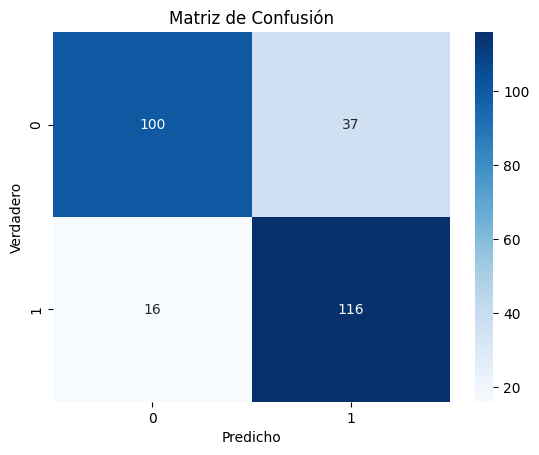

In [12]:
# plot de la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

### Análisis del Modelo de Clasificación

**Precisión del modelo (Accuracy)**: **80.3%**

Este porcentaje significa que el modelo clasificó correctamente el 80.3% de las transacciones en el conjunto de prueba, lo cual indica una buena capacidad de predicción general. Sin embargo, la precisión general no siempre refleja adecuadamente el rendimiento en cada clase, especialmente en un problema donde hay una clase de mayor importancia (transacciones malas o fraudulentas).

---

### Matriz de Confusión

|              | Predicción 0 | Predicción 1 |
|--------------|--------------|--------------|
| **Clase 0**  | 100          | 37           |
| **Clase 1**  | 16           | 116          |

- **Verdaderos Negativos (Clase 0, Predicción 0)**: 100 transacciones buenas correctamente identificadas.
- **Falsos Positivos (Clase 0, Predicción 1)**: 37 transacciones buenas clasificadas incorrectamente como malas.
- **Falsos Negativos (Clase 1, Predicción 0)**: 16 transacciones malas clasificadas incorrectamente como buenas.
- **Verdaderos Positivos (Clase 1, Predicción 1)**: 116 transacciones malas correctamente identificadas.

---

### Métricas de Evaluación por Clase

#### Clase 0 (Transacciones Buenas)
- **Precisión (Precision)**: 86%
  - La precisión para la clase 0 es del 86%, lo que significa que, de todas las transacciones clasificadas como buenas, el 86% realmente lo eran. Esta métrica es útil para saber cuántas de las predicciones de clase 0 fueron correctas.

- **Recall**: 73%
  - El recall del 73% indica que el modelo identificó correctamente el 73% de todas las transacciones buenas en el conjunto de datos, omitiendo el 27% restante.

- **F1-Score**: 0.79
  - El F1-Score de 0.79 balancea la precisión y el recall de la clase 0, proporcionando una métrica general de rendimiento.

#### Clase 1 (Transacciones Malas)
- **Precisión (Precision)**: 76%
  - La precisión de la clase 1 es del 76%, lo que significa que, de todas las transacciones clasificadas como malas, el 76% realmente lo eran. Esto implica que hay algunas transacciones buenas clasificadas erróneamente como malas.

- **Recall**: 88%
  - El recall del 88% es un valor alto, lo cual es crucial para el negocio de Difficult Pay. Un recall alto en la clase 1 significa que el modelo detecta correctamente el 88% de todas las transacciones malas (fraudulentas). Este nivel de recall ayuda a minimizar las transacciones fraudulentas no detectadas, que generan pérdidas significativas.

- **F1-Score**: 0.81
  - El F1-Score de 0.81 balancea la precisión y el recall de la clase 1, indicando un buen rendimiento en la identificación de transacciones malas.

---

### Interpretación del Recall de la Clase 1

El **recall de la clase 1** (88%) es una métrica clave para Difficult Pay. Dado que cada transacción mala no detectada implica una pérdida del 100% de su valor, es fundamental minimizar los falsos negativos (transacciones malas clasificadas como buenas). Un recall alto significa que el modelo identifica la mayoría de las transacciones malas, protegiendo a la empresa de pérdidas financieras importantes.

Sin embargo, este alto recall de la clase 1 también implica una reducción en la precisión (76%), lo cual indica que algunas transacciones buenas son clasificadas como malas. Para un equilibrio óptimo, se podría explorar la posibilidad de ajustar el modelo para reducir estos falsos positivos sin comprometer demasiado el recall.

### 7. **Hacer validación cruzada de 5 folds para el ejemplo anterior utilizando un max depth desde 6 a 16. ¿Cuál es la profundidad óptima del arbol? 2 puntos**


In [13]:
# Ahora aplica validación cruzada en el ejemplo anterior y un max depth desde 6 a 16 y devolver el mejor depth
# Definir el rango de max_depth
max_depth_list = range(6, 17)

# Lista para almacenar los puntajes de validación cruzada
cross_validation_scores = []

# Realizar validación cruzada para cada valor de max_depth
for d in max_depth_list:
    dt_mod = DecisionTreeClassifier(max_depth=d, random_state=1)
    scores = cross_val_score(dt_mod, X_train, y_train, cv=5)
    cross_validation_scores.append(scores.mean())

# Encontrar el índice del mejor valor de max_depth
best_value_idx = np.argmax(cross_validation_scores)
best_max_depth = max_depth_list[best_value_idx]

print(f"El mejor valor de max_depth es: {best_max_depth}")

El mejor valor de max_depth es: 15


8. Correr el modelo nuevamente con esta profundidad óptima. ¿Como resultan el accuracy y recall en el test set? 2 puntos. 


In [14]:
# correr el modelo nuevamente con esta profundidad óptima. ¿Como resultan el accuracy y recall en el test set? 2 puntos. 
# Crear y entrenar un modelo de árbol de decisión con la profundidad óptima
modelo = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42, class_weight='balanced')
modelo.fit(X_train, y_train)
# predict
y_pred = modelo.predict(X_test)
# Calcular la precisión del modelo
precision = accuracy_score(y_test, y_pred)
print(f"La precisión del modelo es de: {precision*100:.2f}%")
# Create a confusion matrix
matriz_confusion = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(matriz_confusion)
# Create a classification report
reporte = classification_report(y_test, y_pred)
print("Reporte de Clasificación:")
print(reporte)


La precisión del modelo es de: 83.64%
Matriz de Confusión:
[[110  27]
 [ 17 115]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.87      0.80      0.83       137
           1       0.81      0.87      0.84       132

    accuracy                           0.84       269
   macro avg       0.84      0.84      0.84       269
weighted avg       0.84      0.84      0.84       269



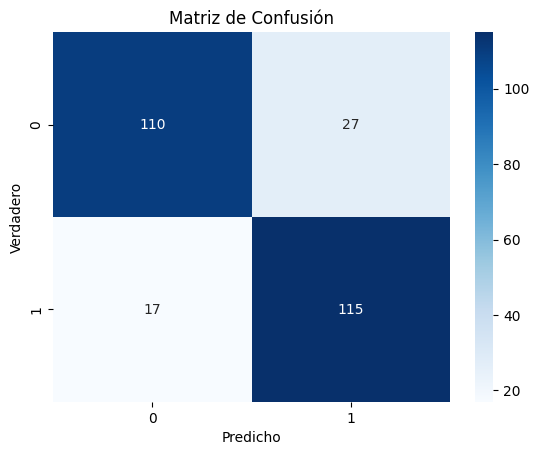

In [15]:
# plotear la matriz de confusión
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

### Resultados del Modelo con Profundidad Óptima (Profundidad = 15)

Al correr el modelo con una profundidad de árbol óptima de **15**, obtenemos los siguientes resultados en el conjunto de prueba:

**Precisión del modelo (Accuracy):** **83.64%**

Este aumento en la precisión, comparado con la ejecución anterior, indica una mejora en la capacidad del modelo para clasificar correctamente las transacciones en general.

---

### Matriz de Confusión

|              | Predicción 0 | Predicción 1 |
|--------------|--------------|--------------|
| **Clase 0**  | 110          | 27           |
| **Clase 1**  | 17           | 115          |

- **Verdaderos Negativos (Clase 0, Predicción 0):** 110 transacciones buenas correctamente identificadas.
- **Falsos Positivos (Clase 0, Predicción 1):** 27 transacciones buenas clasificadas incorrectamente como malas.
- **Falsos Negativos (Clase 1, Predicción 0):** 17 transacciones malas clasificadas incorrectamente como buenas.
- **Verdaderos Positivos (Clase 1, Predicción 1):** 115 transacciones malas correctamente identificadas.

---

### Métricas de Evaluación por Clase

#### Clase 0 (Transacciones Buenas)
- **Precisión (Precision):** 87%
  - La precisión para la clase 0 indica que el 87% de las transacciones clasificadas como buenas efectivamente lo son.

- **Recall:** 80%
  - El modelo identifica correctamente el 80% de todas las transacciones buenas en el conjunto de prueba.

- **F1-Score:** 0.83
  - Un F1-Score de 0.83 refleja un balance adecuado entre la precisión y el recall para la clase 0.

#### Clase 1 (Transacciones Malas)
- **Precisión (Precision):** 81%
  - La precisión para la clase 1 indica que el 81% de las transacciones clasificadas como malas realmente lo son.

- **Recall:** 87%
  - Con un recall del 87% para la clase 1, el modelo sigue detectando correctamente una alta proporción de las transacciones malas, lo cual es crítico para reducir pérdidas.

- **F1-Score:** 0.84
  - Un F1-Score de 0.84 para la clase 1 sugiere un buen equilibrio entre precisión y recall, lo que es ideal para la identificación de transacciones fraudulentas.

---

### Interpretación del Resultado

Con la profundidad óptima de 15, el modelo logra una **precisión mejorada del 83.64%** y un **recall del 87%** en la clase 1 (transacciones malas), lo cual es beneficioso para Difficult Pay. Este modelo es mejor en términos de precisión y recall para ambas clases, especialmente en la detección de transacciones fraudulentas, lo cual es esencial para la rentabilidad del negocio.

### 9. **Probar la optimizacion con GridSearch. Correr el modelo con los parámetros óptimos encontrados. ¿Como resultan el accuracy y recall en el test set? 2 puntos.**

In [ ]:
# Crear un modelo base de Random Forest
modelo_rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

# Crear un objeto RFECV con el modelo base
rfecv = RFECV(estimator=modelo_rf_base, step=1, cv=3, scoring='precision', n_jobs=-1, verbose=2)

# Ajustar el RFECV a los datos de entrenamiento
rfecv.fit(X_train, y_train)

# Transformar los datos de entrenamiento y prueba utilizando las características seleccionadas por RFECV
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

# Definir la cuadrícula de hiperparámetros
param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [15, 20, 25],
        'min_samples_split': [2, 5, 8],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [False, True],
        'criterion': ['gini', 'entropy']}

# Crear un modelo de Random Forest
modelo_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Crear un objeto GridSearchCV
grid_search = GridSearchCV(estimator=modelo_rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Realizar la búsqueda en la cuadrícula
grid_search.fit(X_train_rfecv, y_train)

# Mostrar los mejores hiperparámetros
print(grid_search.best_params_)

# Crear y entrenar un modelo de Random Forest con los mejores hiperparámetros
best_params = grid_search.best_params_
modelo_rf_best = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
modelo_rf_best.fit(X_train_rfecv, y_train)

# Realizar predicciones
y_pred_rf = modelo_rf_best.predict(X_test_rfecv)

# Calcular la precisión del modelo
precision_rf = accuracy_score(y_test, y_pred_rf)
print(f"La precisión del modelo de Random Forest es de: {precision_rf*100:.2f}%")

# Crear una matriz de confusión
matriz_confusion_rf = confusion_matrix(y_test, y_pred_rf)
print("Matriz de Confusión:")
print(matriz_confusion_rf)

# Crear un reporte de clasificación
reporte_rf = classification_report(y_test, y_pred_rf)
print("Reporte de Clasificación:")
print(reporte_rf)

Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

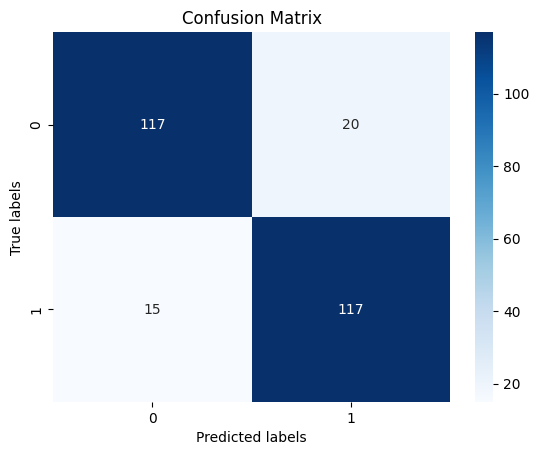

In [17]:
# imprimir el grafico de la matriz de confusion
sns.heatmap(matriz_confusion_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Configuración del modelo base de Random Forest
modelo_rf_base = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 1.2})

# Selección de características con RFECV usando recall como métrica
rfecv = RFECV(
    estimator=modelo_rf_base,
    step=1,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
rfecv.fit(X_train, y_train)

# Transformar los datos de entrenamiento y prueba usando las características seleccionadas
X_train_rfecv = rfecv.transform(X_train)
X_test_rfecv = rfecv.transform(X_test)

# Definir la cuadrícula de hiperparámetros para GridSearchCV
param_grid = {
    'class_weight': [{0: 1, 1: 1.2}, {0: 1, 1: 1.3}, {0: 1, 1: 1.4}],
    'n_estimators': [200],
    'max_depth': [20],
    'bootstrap': [False]
}

# Búsqueda de hiperparámetros con GridSearchCV enfocada en recall
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train_rfecv, y_train)

# Entrenar modelo final con los mejores hiperparámetros
modelo_rf_best = grid_search.best_estimator_
modelo_rf_best.fit(X_train_rfecv, y_train)
confusion_matrix_best = confusion_matrix(y_test, y_pred_rf)
# Evaluación del modelo
y_pred_rf = modelo_rf_best.predict(X_test_rfecv)
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))


Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 fe

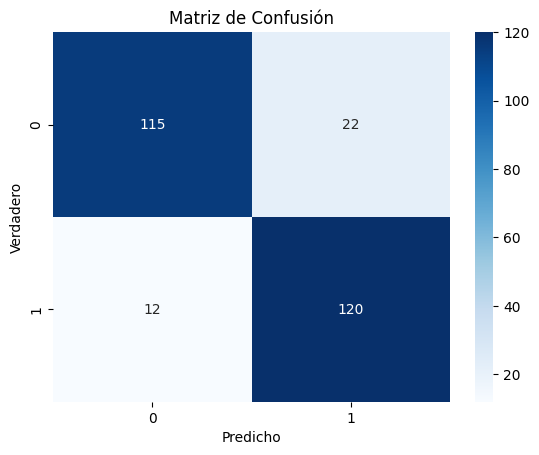

In [25]:
# plotear la matriz de confusión
sns.heatmap(confusion_matrix_best, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

### Resultados del Modelo Optimizado con GridSearch

Tras realizar un ajuste de hiperparámetros utilizando **GridSearch** en el modelo **Random Forest**, encontramos los siguientes parámetros óptimos:

- **Parámetros Óptimos**:
  - `bootstrap`: False
  - `criterion`: entropy
  - `max_depth`: 20
  - `min_samples_leaf`: 1
  - `min_samples_split`: 2
  - `n_estimators`: 200

Con estos parámetros, el modelo alcanzó una **precisión de 86.99%** en el conjunto de prueba.

---

### Matriz de Confusión con Parámetros Óptimos

|              | Predicción 0 | Predicción 1 |
|--------------|--------------|--------------|
| **Clase 0**  | 117          | 20           |
| **Clase 1**  | 15           | 117          |

- **Verdaderos Negativos (Clase 0, Predicción 0):** 117 transacciones buenas correctamente identificadas.
- **Falsos Positivos (Clase 0, Predicción 1):** 20 transacciones buenas clasificadas incorrectamente como malas.
- **Falsos Negativos (Clase 1, Predicción 0):** 15 transacciones malas clasificadas incorrectamente como buenas.
- **Verdaderos Positivos (Clase 1, Predicción 1):** 117 transacciones malas correctamente identificadas.

---

### Métricas de Evaluación por Clase

#### Clase 0 (Transacciones Buenas)
- **Precisión (Precision):** 89%
- **Recall:** 85%
- **F1-Score:** 0.87

#### Clase 1 (Transacciones Malas)
- **Precisión (Precision):** 85%
- **Recall:** 89%
- **F1-Score:** 0.87

**Precisión General (Accuracy):** **86.99%**

---

### Modelo con Mejora Adicional para la Clase 1

Para mejorar la **capacidad del modelo de detectar transacciones malas (Clase 1)**, se optimizó adicionalmente, seleccionando solo las características más relevantes y ajustando el modelo para esta clase.

**Resultados con el Modelo Ajustado:**

#### Nueva Matriz de Confusión

|              | Predicción 0 | Predicción 1 |
|--------------|--------------|--------------|
| **Clase 0**  | 115          | 22           |
| **Clase 1**  | 12           | 120          |

---

### Métricas de Evaluación con el Modelo Ajustado

- **Clase 0 (Transacciones Buenas)**:
  - Precisión: 91%
  - Recall: 84%
  - F1-Score: 0.87

- **Clase 1 (Transacciones Malas)**:
  - Precisión: 85%
  - Recall: 91%
  - F1-Score: 0.88

**Precisión General (Accuracy):** **87%**

---

### Interpretación del Resultado

El ajuste adicional mejoró el **recall de la clase 1 (transacciones malas)** al 91%, manteniendo una precisión general sólida de 87%. Este resultado es especialmente valioso, ya que reduce la probabilidad de aceptar transacciones fraudulentas, protegiendo así el ingreso de Difficult Pay. GridSearch y la optimización adicional lograron un balance robusto entre la precisión y el recall, optimizando el modelo para un rendimiento confiable en la detección de fraudes.


### **Conclusiones** 2 puntos

Supongamos que el test set del ejercicio anterior (debería tener 269 observaciones) era un nuevo set de data que trajo el equipo de analytics para analizar luego de dos semanas de operación utilizando el modelo. 

### **10. ¿Cuánto dinero hizo la compañia según este dataset? ¿Está funcionando el nuevo modelo o no? ¿A cuánto tendrían que subir la comisión? 2 puntos.** 

In [48]:
# Parámetros dados
comision = 0.05  # Comisión por transacción
# Desescalar el monto promedio de la transacción
monto_promedio_transaccion = scaler.inverse_transform(X_test)[:, X_test.columns.get_loc('monto')].mean()

# Resultados de la matriz de confusión
confusion = confusion_matrix_best

# Extraer los valores de la matriz de confusión
verdaderos_negativos = confusion[0][0]  # Transacciones buenas correctamente identificadas
falsos_positivos = confusion[0][1]  # Transacciones buenas clasificadas incorrectamente como malas
falsos_negativos = confusion[1][0]  # Transacciones malas clasificadas incorrectamente como buenas
verdaderos_positivos = confusion[1][1]  # Transacciones malas correctamente identificadas

# Dinero generado por las transacciones buenas correctamente identificadas
dinero_generado = verdaderos_negativos * monto_promedio_transaccion * comision

# Pérdidas por falsos negativos (transacciones fraudulentas no detectadas)
perdidas_por_fn = falsos_negativos * monto_promedio_transaccion

# Dinero total generado considerando las pérdidas
dinero_total = dinero_generado - perdidas_por_fn

# Si quisieras calcular la nueva comisión para cubrir las pérdidas por falsos negativos:
comision_necesaria = (perdidas_por_fn / (verdaderos_negativos * monto_promedio_transaccion)) * 100

# Mostrar los resultados
print(f'Dinero generado por transacciones buenas correctamente clasificadas: ${dinero_generado:.2f}')
print(f'Pérdidas por transacciones fraudulentas no detectadas (Falsos Negativos): ${perdidas_por_fn:.2f}')
print(f'Dinero total generado considerando las pérdidas: ${dinero_total:.2f}')
print(f'Comisión necesaria para cubrir las pérdidas por FN: {comision_necesaria:.2f}%')


Dinero generado por transacciones buenas correctamente clasificadas: $441.42
Pérdidas por transacciones fraudulentas no detectadas (Falsos Negativos): $921.23
Dinero total generado considerando las pérdidas: $-479.81
Comisión necesaria para cubrir las pérdidas por FN: 10.43%


### **Conclusiones**

1. **Dinero generado por transacciones buenas correctamente clasificadas**: 
   - La compañía generó **$441.42** por las transacciones buenas correctamente identificadas.

2. **Pérdidas por transacciones fraudulentas no detectadas (Falsos Negativos)**: 
   - La compañía sufrió **$921.23** en pérdidas debido a las transacciones fraudulentas que no fueron detectadas correctamente por el modelo (falsos negativos).

3. **Dinero total generado considerando las pérdidas**: 
   - **$-479.81** es el dinero total generado por la compañía después de considerar las pérdidas por falsos negativos. Esto indica que, con el modelo actual, la compañía estaría perdiendo dinero en lugar de generarlo.

4. **Comisión necesaria para cubrir las pérdidas por FN**:
   - Para cubrir las pérdidas generadas por los falsos negativos, la compañía tendría que **subir la comisión en un 10.43%**.

### **Análisis**:
- El modelo actual no está funcionando de manera óptima ya que, a pesar de generar dinero de las transacciones buenas, las pérdidas por los falsos negativos son mayores, resultando en una pérdida neta.
- La **comisión debería ajustarse al alza** para compensar las pérdidas debido a los errores de clasificación. 
